In [11]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "./raw_data/exchange_rate.h5"

with h5py.File(file, "r") as f:
    RawData = np.array(f["raw_data"])
    time = np.array(f["time"])
    print("number of occurences:", len(time)) # check the keys

# --- Clean up shapes ---
RawData = np.squeeze(RawData)  


time = [t.decode() for t in time]
time = pd.to_datetime(time)
print(time)


number of occurences: 7588
DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10',
               ...
               '2010-10-01', '2010-10-02', '2010-10-03', '2010-10-04',
               '2010-10-05', '2010-10-06', '2010-10-07', '2010-10-08',
               '2010-10-09', '2010-10-10'],
              dtype='datetime64[ns]', length=7588, freq=None)


In [42]:
from functions import linear_piecewise_approximation
import numpy as np


X = np.arange(len(time))
Y = RawData[:, 0]  # Australia (AUD)
alphas, X_ranges = linear_piecewise_approximation(X, Y, epsilon=0.05)


In [43]:
from functions import plot_time_series_with_segments

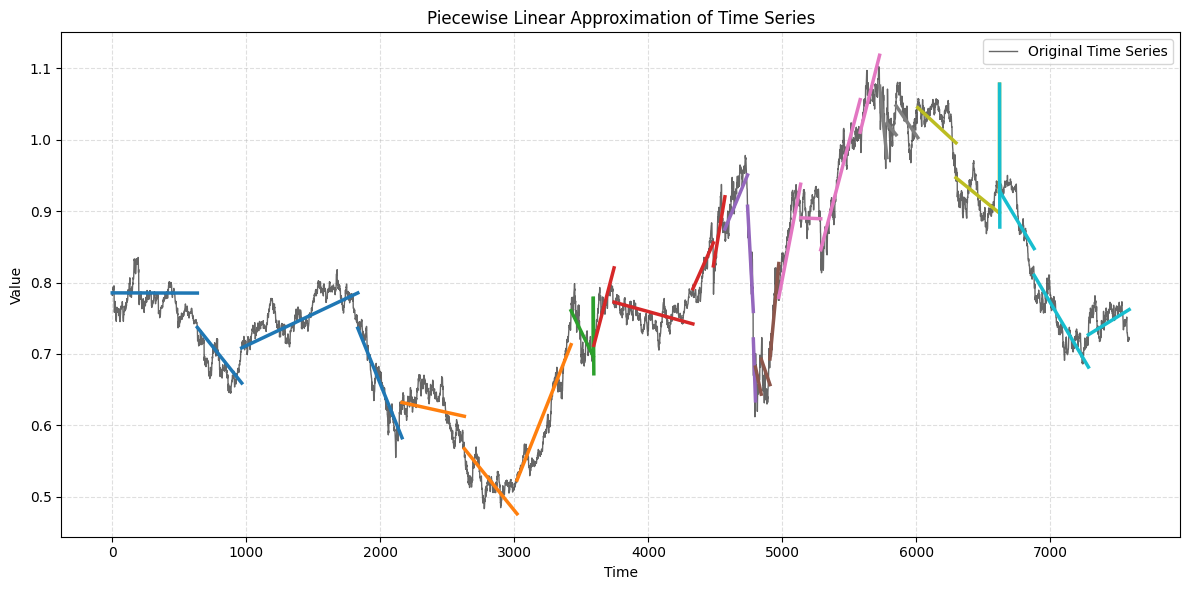

In [44]:
plot_time_series_with_segments(X, Y, alphas, X_ranges)

In [ ]:
import numpy as np

def get_normalized_visual_angles(X, Y, angles_deg, X_ranges):
    """
    Compute the apparent (visual) angles of the linear segments as they appear on a graph,
    by normalizing Δx and Δy to the axis ranges.

    This corresponds to: 
        θ = arctan( (Δy / y_range) / (Δx / x_range) ) * 180 / π
    """

    x_range = X.max() - X.min()
    y_range = Y.max() - Y.min()
    visual_angles = []

    for angle_deg, (start, end) in zip(angles_deg, X_ranges):
        
        slope = np.tan(np.radians(angle_deg))
        x0, x1 = X[start], X[end]
        y0 = Y[start]
        y1 = y0 + slope * (x1 - x0)

        delta_x = (x1 - x0) / x_range
        delta_y = (y1 - y0) / y_range

        slope_vis = delta_y / delta_x
        angle_vis_deg = np.degrees(np.arctan(slope_vis))
        visual_angles.append(angle_vis_deg)

    return visual_angles


In [122]:
graph_angles = get_normalized_visual_angles(X, Y, alphas, X_ranges)

In [124]:
for i, (a_data, a_graph) in enumerate(zip(alphas, graph_angles)):
    print(f"Segment {i+1}: graph angle={a_graph:.3f}°")

Segment 1: graph angle=-0.285°
Segment 2: graph angle=-70.886°
Segment 3: graph angle=47.416°
Segment 4: graph angle=-80.040°
Segment 5: graph angle=-26.939°
Segment 6: graph angle=-70.614°
Segment 7: graph angle=80.158°
Segment 8: graph angle=-78.057°
Segment 9: graph angle=89.941°
Segment 10: graph angle=-89.823°
Segment 11: graph angle=83.516°
Segment 12: graph angle=-32.417°
Segment 13: graph angle=78.997°
Segment 14: graph angle=85.849°
Segment 15: graph angle=79.651°
Segment 16: graph angle=-88.635°
Segment 17: graph angle=-89.136°
Segment 18: graph angle=-84.724°
Segment 19: graph angle=-81.532°
Segment 20: graph angle=87.691°
Segment 21: graph angle=85.203°
Segment 22: graph angle=-5.950°
Segment 23: graph angle=83.487°
Segment 24: graph angle=83.732°
Segment 25: graph angle=-87.429°
Segment 26: graph angle=-70.698°
Segment 27: graph angle=-73.525°
Segment 28: graph angle=-64.745°
Segment 29: graph angle=-61.811°
Segment 30: graph angle=89.969°
Segment 31: graph angle=-89.953°


In [132]:
X_ranges

[(0, 635),
 (635, 966),
 (966, 1832),
 (1832, 2162),
 (2162, 2627),
 (2627, 3020),
 (3020, 3423),
 (3423, 3588),
 (3588, 3589),
 (3589, 3593),
 (3593, 3744),
 (3744, 4332),
 (4332, 4485),
 (4485, 4571),
 (4571, 4740),
 (4740, 4783),
 (4783, 4799),
 (4799, 4842),
 (4842, 4907),
 (4907, 4973),
 (4973, 5136),
 (5136, 5286),
 (5286, 5580),
 (5580, 5725),
 (5725, 5780),
 (5780, 5848),
 (5848, 6010),
 (6010, 6295),
 (6295, 6619),
 (6619, 6620),
 (6620, 6622),
 (6622, 6878),
 (6878, 7283),
 (7283, 7587)]

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def compute_segment_durations_in_days(X, X_ranges, freq_per_day=None):
    """
    Compute segment durations in days given a time axis X and segment index ranges.

    Parameters
    ----------
    X : array-like
        Time axis (either datetime or numeric).
    X_ranges : list of (start_idx, end_idx)
        Segment boundaries.
    freq_per_day : float, optional
        If X is numeric (e.g., hours), specify how many samples per day (e.g., 24).

    Returns
    -------
    durations_days : list of float
        Duration of each segment in days.
    """
    durations_days = []

    # Detect if X is datetime-like
    if np.issubdtype(np.array(X).dtype, np.datetime64):
        for start, end in X_ranges:
            delta = X[end] - X[start]
            durations_days.append(delta / np.timedelta64(1, 'D'))  # convert to days
    else:
        # numeric — user must provide freq_per_day
        if freq_per_day is None:
            raise ValueError("Please provide freq_per_day if X is not datetime-like.")
        for start, end in X_ranges:
            delta = (X[end] - X[start]) / freq_per_day
            durations_days.append(delta)

    return durations_days


def plot_trend_duration_histogram(X, X_ranges, freq_per_day=None):
    """
    Plot a histogram of linguistic trend durations: short (1–10 days),
    medium (10–30 days), and long (>30 days).

    Parameters
    ----------
    X : array-like
        Time axis (either datetime or numeric).
    X_ranges : list of (start_idx, end_idx)
        Segment boundaries.
    freq_per_day : float, optional
        If X is numeric (e.g., hourly), specify how many samples per day.
    """
    durations_days = compute_segment_durations_in_days(X, X_ranges, freq_per_day=freq_per_day)
    durations_days = np.array(durations_days)

    # Categorize each segment linguistically
    categories = []
    for d in durations_days:
        if d <= 10:
            categories.append("short trend")
        elif d <= 30:
            categories.append("medium trend")
        else:
            categories.append("long trend")

    # Count each category
    counts = pd.Series(categories).value_counts().reindex(
        ["short trend", "medium trend", "long trend"], fill_value=0
    )

    # Plot histogram
    plt.figure(figsize=(7, 5))
    counts.plot(kind='bar', color=['lightgreen', 'gold', 'salmon'], edgecolor='black')
    plt.title("Linguistic Histogram of Trend Durations")
    plt.xlabel("Trend Duration Category")
    plt.ylabel("Number of Segments")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Print summary
    print(f"Average duration: {np.mean(durations_days):.2f} days")
    print(f"Median duration: {np.median(durations_days):.2f} days")
    print(f"→ Linguistic breakdown:\n{counts.to_string()}")


In [ ]:
def linguistic_summary(angle_deg):
    """
    Provide a linguistic summary based on the angle in degrees.
    """
    if angle_deg > 45:
        return "steeply increasing"
    elif 15 < angle_deg <= 45:
        return "moderately increasing"
    elif -15 <= angle_deg <= 15:
        return "stable"
    elif -45 <= angle_deg < -15:
        return "moderately decreasing"
    else:  # angle_deg < -45
        return "steeply decreasing"







    

def plot_histogram_of_angles(angles_deg):
    """
    Plot a histogram of the angles in degrees.
    """
    plt.figure(figsize=(8, 5))
    plt.hist(angles_deg, bins=20, color='skyblue', edgecolor='black')
    plt.title("Histogram of Segment Angles")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

def plot_histograms_of_linguistic_summaries(angles_deg):
    """
    Plot histograms of linguistic summaries based on the angles.
    """
    summaries = [linguistic_summary(angle) for angle in angles_deg]
    summary_counts = pd.Series(summaries).value_counts()
    order = ["steeply increasing", "moderately increasing", "stable", "moderately decreasing", "steeply decreasing"]
    summary_counts = summary_counts.reindex(order).fillna(0)


    plt.figure(figsize=(8, 5))
    summary_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title("Histogram of Linguistic Summaries")
    plt.xlabel("Linguistic Summary")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_histograms_of_variability(Y, X_ranges):
    """
    Compute the standard deviation within each segment and
    plot a linguistic histogram of segment variability.

    Parameters
    ----------
    Y : array-like
        Time-series values (e.g. CO(GT), temperature, etc.)
    X_ranges : list of (start_idx, end_idx)
        List of (start, end) index pairs for each segment.
    """
    std_values = []
    variability_labels = []

    # --- Compute std for each segment
    for (start, end) in X_ranges:
        segment = np.array(Y[start:end+1], dtype=float)
        std = np.std(segment) if len(segment) > 1 else 0.0
        std_values.append(std)
        print(f"Segment {start}-{end}: std={std:.3f}")
        # --- Linguistic classification
        if std < 0.03:
            variability_labels.append("low variability")
        elif std < 0.05:
            variability_labels.append("moderate variability")
        else:
            variability_labels.append("high variability")

    # --- Count the linguistic classes
    counts = pd.Series(variability_labels).value_counts().reindex(
        ["low variability", "moderate variability", "high variability"], fill_value=0
    )

    # --- Plot histogram
    plt.figure(figsize=(7, 5))
    counts.plot(kind='bar', color=['lightgreen', 'gold', 'salmon'], edgecolor='black')
    plt.title("Linguistic Histogram of Segment Variability (per-segment σ)")
    plt.xlabel("Variability Category")
    plt.ylabel("Number of Segments")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Print summary stats
    print(f"Number of segments: {len(std_values)}")
    print(f"Mean σ = {np.mean(std_values):.2f}")
    print(f"Median σ = {np.median(std_values):.2f}")
    print(f"→ Distribution:\n{counts.to_string()}")


Segment 0-635: std=0.020
Segment 635-966: std=0.022
Segment 966-1832: std=0.026
Segment 1832-2162: std=0.050
Segment 2162-2627: std=0.027
Segment 2627-3020: std=0.017
Segment 3020-3423: std=0.063
Segment 3423-3588: std=0.031
Segment 3588-3589: std=0.040
Segment 3589-3593: std=0.028
Segment 3593-3744: std=0.021
Segment 3744-4332: std=0.016
Segment 4332-4485: std=0.032
Segment 4485-4571: std=0.036
Segment 4571-4740: std=0.031
Segment 4740-4783: std=0.041
Segment 4783-4799: std=0.030
Segment 4799-4842: std=0.020
Segment 4842-4907: std=0.025
Segment 4907-4973: std=0.037
Segment 4973-5136: std=0.042
Segment 5136-5286: std=0.019
Segment 5286-5580: std=0.061
Segment 5580-5725: std=0.025
Segment 5725-5780: std=0.030
Segment 5780-5848: std=0.020
Segment 5848-6010: std=0.030
Segment 6010-6295: std=0.023
Segment 6295-6619: std=0.022
Segment 6619-6620: std=0.076
Segment 6620-6622: std=0.071
Segment 6622-6878: std=0.045
Segment 6878-7283: std=0.032
Segment 7283-7587: std=0.015


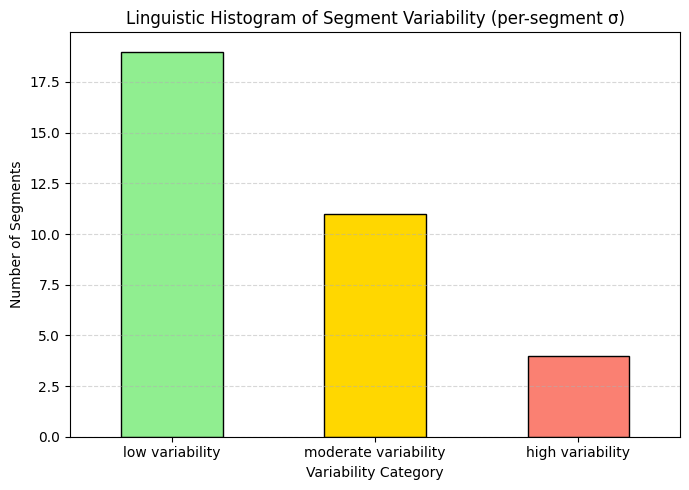

Number of segments: 34
Mean σ = 0.03
Median σ = 0.03
→ Distribution:
low variability         19
moderate variability    11
high variability         4


In [147]:
plot_histograms_of_variability(Y,X_ranges)

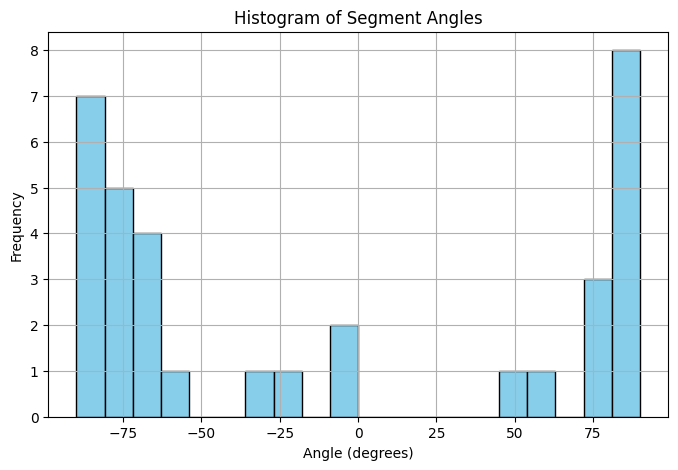

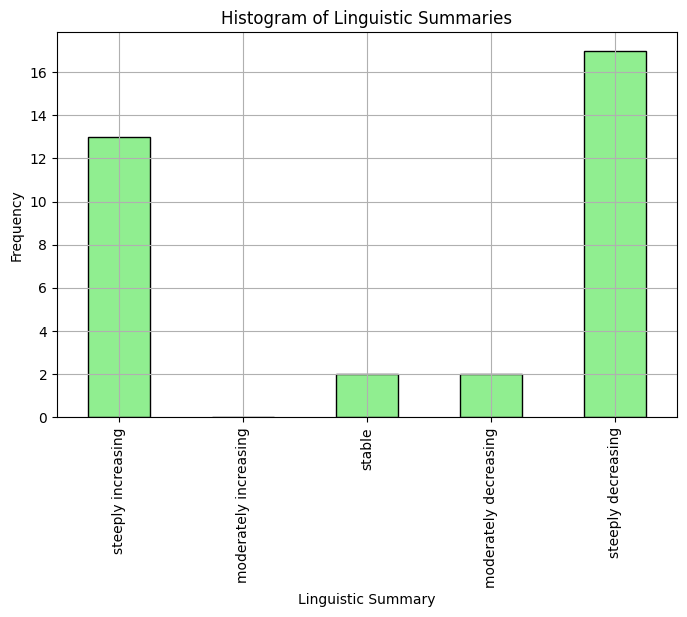

In [131]:
plot_histogram_of_angles(graph_angles)
plot_histograms_of_linguistic_summaries(graph_angles)

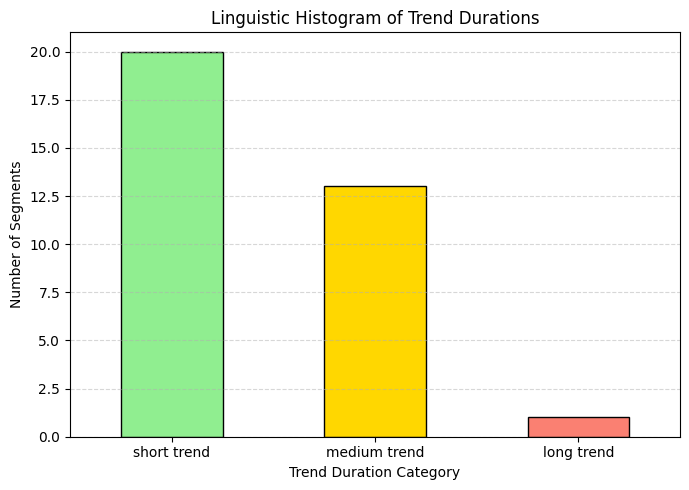

Average duration: 9.30 days
Median duration: 6.77 days
→ Linguistic breakdown:
short trend     20
medium trend    13
long trend       1


In [148]:
plot_trend_duration_histogram(X, X_ranges, freq_per_day=24)

In [149]:
def fuzzy_quantifier(q_name):
    """
    Return a fuzzy quantifier μ_Q(x) in [0,1].
    x is a proportion of trends (or time) ∈ [0,1].
    """
    def Q(x):
        if q_name == "almost_all":
            # rises steeply near 1
            if x < 0.7: return 0
            elif x < 0.9: return (x - 0.7) / 0.2
            else: return 1
        elif q_name == "most":
            if x < 0.4: return 0
            elif x < 0.6: return (x - 0.4) / 0.2
            else: return 1
        elif q_name == "half":
            # around 0.5 ± 0.2
            if x < 0.3: return 0
            elif x < 0.5: return (x - 0.3) / 0.2
            elif x < 0.7: return 1 - (x - 0.5) / 0.2
            else: return 0
        elif q_name == "almost_none":
            # symmetric of "almost all"
            if x > 0.3: return 0
            elif x > 0.1: return (0.3 - x) / 0.2
            else: return 1
        else:
            raise ValueError(f"Unknown quantifier '{q_name}'")
    return np.vectorize(Q)


In [150]:
def mu_short(d):     # duration in days
    if d <= 5: return 1
    elif d <= 10: return (10 - d) / 5
    else: return 0

def mu_medium(d):
    if 5 < d < 15: return (d - 5) / 10
    elif 15 <= d <= 30: return 1 - (d - 15) / 15
    else: return 0

def mu_long(d):
    if d <= 20: return 0
    elif d <= 40: return (d - 20) / 20
    else: return 1


In [151]:
def mu_low_var(sigma):
    if sigma <= 0.02: return 1
    elif sigma <= 0.03: return (0.03 - sigma) / 0.01
    else: return 0

def mu_moderate_var(sigma):
    if 0.02 < sigma < 0.04: return (sigma - 0.02) / 0.02
    elif 0.04 <= sigma <= 0.06: return 1 - (sigma - 0.04) / 0.02
    else: return 0

def mu_high_var(sigma):
    if sigma <= 0.05: return 0
    elif sigma <= 0.07: return (sigma - 0.05) / 0.02
    else: return 1


In [152]:
def mu_increasing(angle):
    if angle <= 1: return 0
    elif angle <= 3: return (angle - 1) / 2
    else: return 1

def mu_decreasing(angle):
    if angle >= -1: return 0
    elif angle >= -3: return (-angle - 1) / 2
    else: return 1

def mu_constant(angle):
    return max(0, 1 - abs(angle) / 3)


In [154]:
durations_days = [ X_range[1] - X_range[0] for X_range in X_ranges ]


mu_P = [mu_constant(a) for a in graph_angles]
mu_R = [mu_medium(d) for d in durations_days]
durations = durations_days


In [160]:
import numpy as np
from functions import t_norms


def truth_extended_duration_summary(mu_P, mu_R, durations,
                                    quantifier="most", norm_type="min"):
    """
    Compute the fuzzy truth value of an extended duration-based summary:
        "Among all R trends, P trends took Q time"

    Implements Equation (18) from Kacprzyk, Wilbik & Zadrożny (2010).

    Parameters
    ----------
    mu_P : array-like of float
        Membership degrees μ_P(y_i) for predicate P (e.g., "low variability").
    mu_R : array-like of float
        Membership degrees μ_R(y_i) for predicate R (e.g., "short duration").
    durations : array-like of float
        Duration t_{y_i} of each trend (e.g., in days or hours).
    quantifier : str
        Linguistic quantifier ("almost_all", "most", "half", "almost_none").
    norm_type : str
        Type of t-norm to use ("min", "prod", "lukasiewicz", "drastic").

    Returns
    -------
    float : truth value in [0, 1]
    """

    mu_P = np.asarray(mu_P, dtype=float)
    mu_R = np.asarray(mu_R, dtype=float)
    durations = np.asarray(durations, dtype=float)

    # get the t-norm operation
    t = t_norms(norm_type)

    # total duration weighted by μ_R
    denominator = np.sum(mu_R * durations)
    if denominator == 0:
        return 0.0

    # numerator: weighted by t(μ_R, μ_P)
    numerator = np.sum([t(mu_R[i], mu_P[i]) * durations[i]
                        for i in range(len(durations))])

    ratio = numerator / denominator  # ∈ [0, 1]

    # apply fuzzy quantifier μ_Q
    mu_Q = fuzzy_quantifier(quantifier)
    return float(mu_Q(ratio))


In [161]:



T1 = truth_extended_duration_summary(mu_P, mu_R, durations,
                                     quantifier="almost_all", norm_type="min")
print("→ almost all trends of medium duration are constant:", round(T1, 3))


TypeError: 'NoneType' object is not callable